In [85]:
import baseline_script
import pandas as pd
from preprocess import load_data_and_preprocess
import text_irsystem
import visual_irsystem
import audio_irsystem
from metrics import NDCGAtK, DiversityAtK, MetricsEvaluation, Popularity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
tracks = load_data_and_preprocess()

Loading datasets...
Preprocessing tracks...


In [50]:
bert = text_irsystem.TextIRSystem(tracks, 'bert')
resnet = visual_irsystem.VisualIRSystem(tracks, 'resnet')
musicnn = audio_irsystem.AudioIRSystem(tracks, 'musicnn')
tdidf = text_irsystem.TextIRSystem(tracks, 'tfidf')
blf = visual_irsystem.VisualIRSystem(tracks, 'vgg19')
vgg = audio_irsystem.AudioIRSystem(tracks, 'spectral')
baseline = baseline_script.BaselineIRSystem(tracks)
irs = [bert, resnet, musicnn, tdidf, blf, vgg, baseline]

In [53]:
evaluation_protocol = MetricsEvaluation(tracks)

In [102]:
results = {
    "ndcg10": [],
    "ndcg50": [],
    "ndcg100": [],
    "ndcg500": [],
    "div10": [],
    "div50": [],
    "div100": [],}
for ir_system in irs:

    ndcg_scores10 = []
    ndcg_scores50 = []
    ndcg_scores100 = []
    diversity_scores10 = []
    diversity_scores50 = []
    diversity_scores100 = []

    for index, query_track in enumerate(tracks):
        relevant_ids = [
            track.track_id
            for track in tracks
            if track.track_id != query_track.track_id and (
                any(top_genre in track.top_genres for top_genre in query_track.top_genres)
            )
        ]
        
        recommended_tracks, _ = ir_system.query(query_track, n=100)
        recommended_ids = [track.track_id for track in recommended_tracks]
        for k in [10, 50,100]:
            ndcg_metric = NDCGAtK(k)
            diversity_metric = DiversityAtK(k, threshold=evaluation_protocol.tag_threshold, max_tags=evaluation_protocol.tag_size_threshold)
            ndcg = ndcg_metric.evaluate(recommended_ids[:k], relevant_ids)
            diversity = diversity_metric.evaluate(recommended_tracks[:k], relevant_ids)
            if k == 10:
                ndcg_scores10.append(ndcg)
                diversity_scores10.append(diversity)
            elif k == 50:
                ndcg_scores50.append(ndcg)
                diversity_scores50.append(diversity)
            else:
                ndcg_scores100.append(ndcg)
                diversity_scores100.append(diversity)
    results["ndcg10"].append(np.mean(ndcg_scores10))
    results["ndcg50"].append(np.mean(ndcg_scores50))
    results["ndcg100"].append(np.mean(ndcg_scores100))
    results["div10"].append(np.mean(diversity_scores10))
    results["div50"].append(np.mean(diversity_scores50))
    results["div100"].append(np.mean(diversity_scores100))

nDCG = results["ndcg10"]+ results["ndcg50"]+ results["ndcg100"]
diversity = results["div10"]+results["div50"]+results["div100"]
                

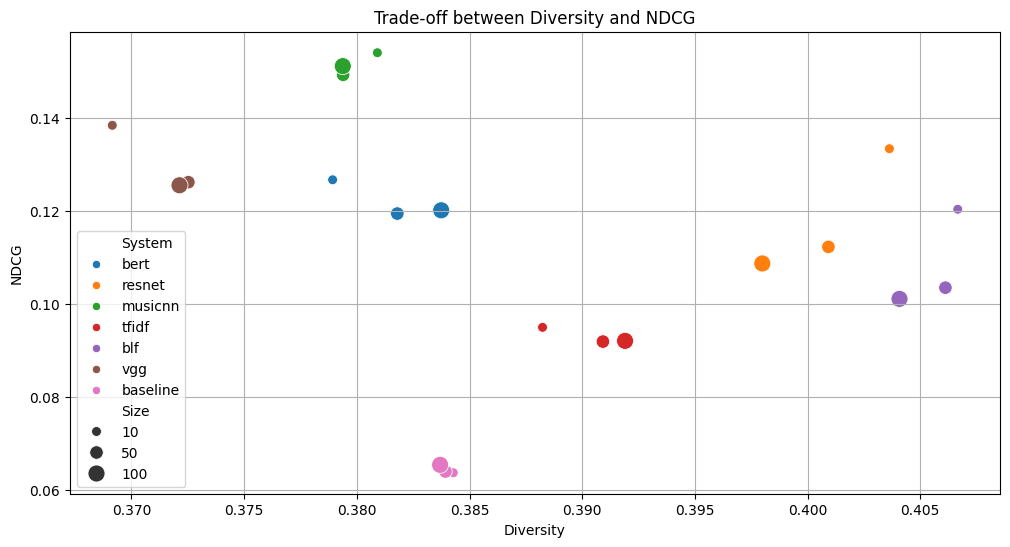

In [115]:
data = {
    "System": ["bert", "resnet", "musicnn", "tfidf", "blf", "vgg", "baseline"] * 3,
    "NDCG": nDCG,
    "Div": diversity,
    "N": [10] * 7 + [50] * 7 + [100] * 7
}
df = pd.DataFrame(data)
size_mapping = {10: 10, 50: 50, 100: 100}
df["Size"] = df["N"].map(size_mapping)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="Div", y="NDCG", hue="System", size="Size", sizes=(50, 150), legend="full")

plt.title("Trade-off between Diversity and NDCG")
plt.xlabel("Diversity")
plt.ylabel("NDCG")
plt.grid(True)
plt.show()

In [88]:
results_pop = {
    "ndcg10": [],
    "ndcg50": [],
    "ndcg100": [],
    "pop10": [],
    "pop50": [],
    "pop100": [],}
for ir_system in irs:

    ndcg_scores10 = []
    ndcg_scores50 = []
    ndcg_scores100 = []
    popularity_scores10 = []
    popularity_scores50 = []
    popularity_scores100 = []

    for index, query_track in enumerate(tracks):
        relevant_ids = [
            track.track_id
            for track in tracks
            if track.track_id != query_track.track_id and (
                any(top_genre in track.top_genres for top_genre in query_track.top_genres)
            )
        ]
        
        recommended_tracks, _ = ir_system.query(query_track, n=500)
        recommended_ids = [track.track_id for track in recommended_tracks]
        for k in [10, 50,100]:
            ndcg_metric = NDCGAtK(k)
            popularity_metric = Popularity()
            ndcg = ndcg_metric.evaluate(recommended_ids[:k], relevant_ids)
            popularity = popularity_metric.evaluate(recommended_tracks[:k], relevant_ids)
            if k == 10:
                ndcg_scores10.append(ndcg)
                popularity_scores10.append(popularity)
            elif k == 50:
                ndcg_scores50.append(ndcg)
                popularity_scores50.append(popularity)
            else:
                ndcg_scores100.append(ndcg)
                popularity_scores100.append(popularity)
    results_pop["ndcg10"].append(np.mean(ndcg_scores10))
    results_pop["ndcg50"].append(np.mean(ndcg_scores50))
    results_pop["ndcg100"].append(np.mean(ndcg_scores100))
    results_pop["pop10"].append(np.mean(popularity_scores10))
    results_pop["pop50"].append(np.mean(popularity_scores50))
    results_pop["pop100"].append(np.mean(popularity_scores100))

nDCG = results_pop["ndcg10"]+ results_pop["ndcg50"]+ results_pop["ndcg100"]
popularity = results_pop["pop10"]+results_pop["pop50"]+results_pop["pop100"]
                

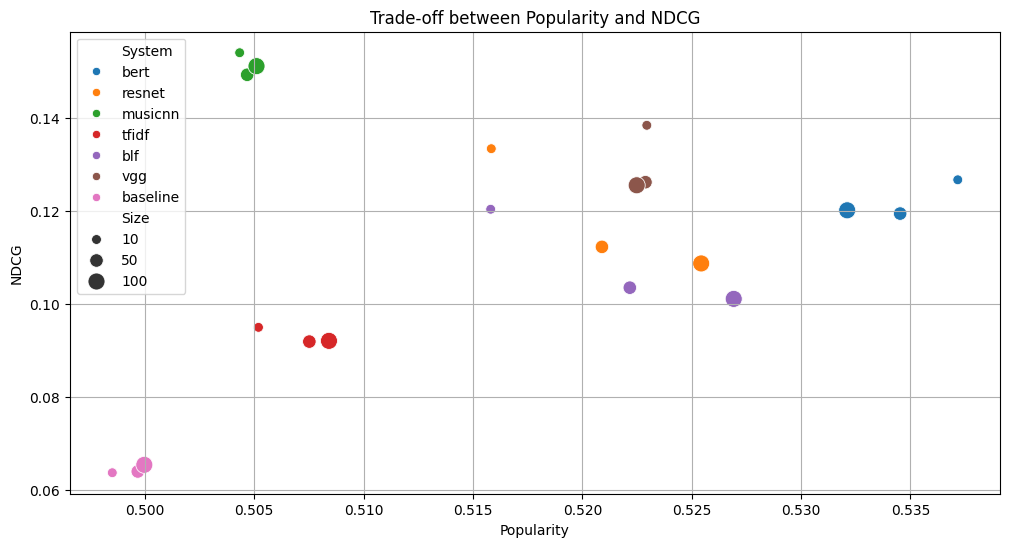

In [114]:
data = {
    "System": ["bert", "resnet", "musicnn", "tfidf", "blf", "vgg", "baseline"] * 3,
    "NDCG": nDCG,
    "Pop": popularity,
    "N": [10] * 7 + [50] * 7 + [100] * 7
}
df = pd.DataFrame(data)

size_mapping = {10: 10, 50: 50, 100: 100} 

df["Size"] = df["N"].map(size_mapping)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="Pop", y="NDCG", hue="System", size="Size", sizes=(50, 150), legend="full")
plt.title("Trade-off between Popularity and NDCG")
plt.xlabel("Popularity")
plt.ylabel("NDCG")
plt.grid(True)
plt.show()